### 1. Cluster Analysis

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor

# ---------------------------
# Load Cleaned Data
# ---------------------------
train_df = pd.read_pickle("lendingclub_curated_2014.pkl")
test_df = pd.read_pickle("lendingclub_curated_2015.pkl")

return_col = "ret_INTc"

# Drop rows without return data
train_df = train_df[train_df[return_col].notnull()].copy()
test_df = test_df[test_df[return_col].notnull()].copy()

# ---------------------------
# Define Features
# ---------------------------
features = [
    'loan_amnt', 'funded_amnt', 'term', 'emp_length', 'home_ownership',
    'annual_inc', 'verification_status', 'purpose', 'dti', 'delinq_2yrs',
    'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'inq_last_6mths',
    'grade', 'int_rate'
]

cat_vars = ['term', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'grade']
num_vars = [col for col in features if col not in cat_vars]

# ---------------------------
# Preprocessing Pipeline
# ---------------------------
preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), num_vars),
    ('cat', Pipeline([
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # FIXED HERE
    ]), cat_vars)
])

# ---------------------------
# Model: Predict Return (Use your best from Update 2)
# ---------------------------
reg_model = Pipeline([
    ('prep', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

X_train = train_df[features]
y_train = train_df[return_col]
X_test = test_df[features]
y_test = test_df[return_col]

# Fit model on training data
reg_model.fit(X_train, y_train)

# Predict returns
train_df['predicted_return'] = reg_model.predict(X_train)
test_df['predicted_return'] = reg_model.predict(X_test)

# ---------------------------
# Clustering on Train Data
# ---------------------------
X_train_scaled = StandardScaler().fit_transform(reg_model.named_steps['prep'].transform(X_train))
kmeans = KMeans(n_clusters=20, random_state=42)
train_clusters = kmeans.fit_predict(X_train_scaled)
train_df['cluster'] = train_clusters

# Calculate cluster-level risk (std dev of predicted return)
cluster_risk_map = train_df.groupby('cluster')['predicted_return'].std().to_dict()
train_df['risk'] = train_df['cluster'].map(cluster_risk_map)

# ---------------------------
# Assign Cluster + Risk to Test Set
# ---------------------------
X_test_scaled = StandardScaler().fit_transform(reg_model.named_steps['prep'].transform(X_test))
test_clusters = kmeans.predict(X_test_scaled)
test_df['cluster'] = test_clusters
test_df['risk'] = test_df['cluster'].map(cluster_risk_map)

# ---------------------------
# Save Enriched Test Set
# ---------------------------
test_df.to_pickle("test_with_predicted_return_and_risk.pkl")
print("Cluster-based predicted return + risk assigned and saved for test set.")


Cluster-based predicted return + risk assigned and saved for test set.


In [ ]:
test_df.to_csv("test_with_predicted_return_and_risk.csv", index=False)


 Cluster Summary (Train Set):
    cluster  cluster_size  mean_return  std_return
0         0          5112         0.08        0.01
1         1          5781         0.08        0.01
2         2          6198         0.08        0.01
3         3         16198         0.08        0.01
4         4            69         0.07        0.04
5         5          9975         0.09        0.02
6         6          9086         0.08        0.01
7         7          8268         0.08        0.03
8         8          9703         0.09        0.01
9         9          5038         0.08        0.01
10       10          3000         0.09        0.04
11       11          1222         0.08        0.02
12       12         10764         0.07        0.01
13       13           898         0.08        0.02
14       14           614         0.08        0.02
15       15          4995         0.08        0.02
16       16             1         0.08         NaN
17       17          1288         0.08        0.03


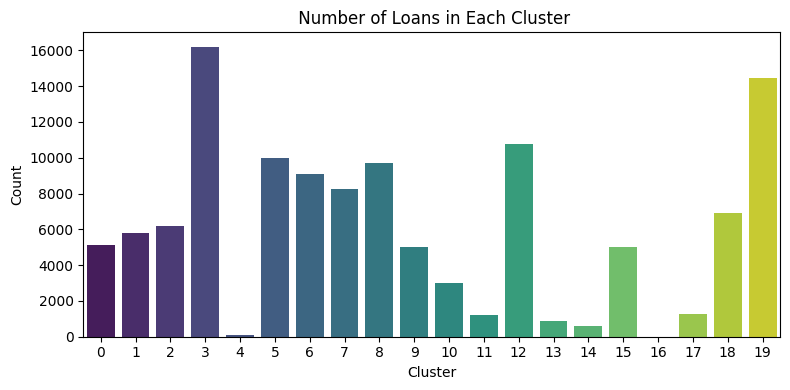

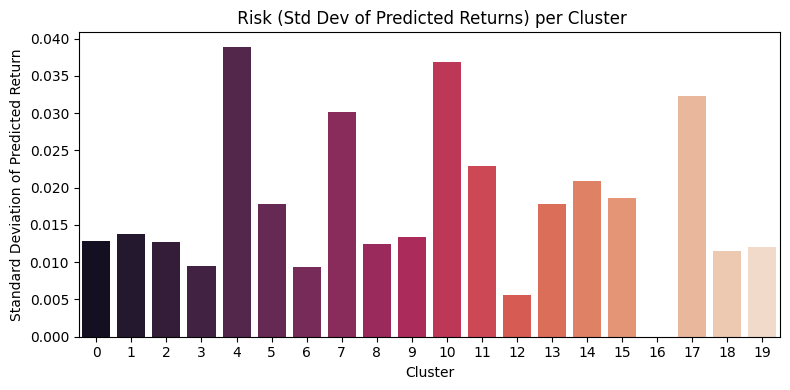

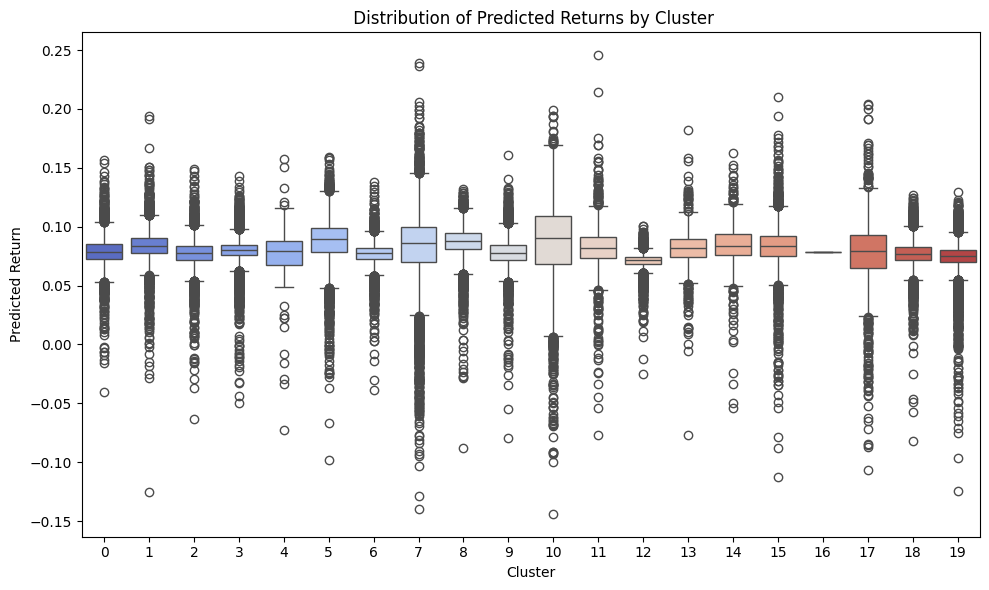

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ---------------------------
# Summary Table
# ---------------------------
cluster_summary = train_df.groupby('cluster').agg(
    cluster_size=('predicted_return', 'count'),
    mean_return=('predicted_return', 'mean'),
    std_return=('predicted_return', 'std')
).reset_index()

print("\n Cluster Summary (Train Set):")
print(cluster_summary.round(2))

# ---------------------------
# Visualization 1: Cluster Sizes
# ---------------------------
plt.figure(figsize=(8, 4))
sns.barplot(x='cluster', y='cluster_size', data=cluster_summary, palette='viridis')
plt.title(" Number of Loans in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ---------------------------
# Visualization 2: Risk (Std Dev) by Cluster
# ---------------------------
plt.figure(figsize=(8, 4))
sns.barplot(x='cluster', y='std_return', data=cluster_summary, palette='rocket')
plt.title(" Risk (Std Dev of Predicted Returns) per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Standard Deviation of Predicted Return")
plt.tight_layout()
plt.show()

# ---------------------------
# Visualization 3: Return Distribution by Cluster
# ---------------------------
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='predicted_return', data=train_df, palette='coolwarm')
plt.title(" Distribution of Predicted Returns by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Predicted Return")
plt.tight_layout()
plt.show()


## Step 1: Risk Estimation via Cluster Analysis

### Objective
To estimate the **risk** of each candidate loan, we use **cluster analysis** on the training set (2014 loans). Risk is defined as the **standard deviation of predicted returns** within each cluster. We then apply these risk estimates to the 2015 loans (test set) by assigning each loan to its **nearest cluster center**.

---

### Methodology

1. **Feature Preparation**:
   - We selected investment-time features (e.g., `loan_amnt`, `term`, `emp_length`, `home_ownership`, etc.).
   - Applied preprocessing: median imputation for numerics and one-hot encoding for categoricals.

2. **Prediction Model**:
   - Used the best model from Week 4: `XGBoost Regressor`.
   - Trained on 2014 data to predict annualized return (`ret_INTc`).

3. **Clustering**:
   - Applied **KMeans clustering** (initially with `k=20`) on the preprocessed features from the 2014 set.
   - Assigned each loan to a cluster.
   - Computed:
     - **Mean predicted return** per cluster.
     - **Standard deviation** (i.e., risk) per cluster.

4. **Assigning Risk to 2015 Test Loans**:
   - Transformed the 2015 loans using the same pipeline.
   - Mapped each loan to the **nearest cluster center** based on Euclidean distance.
   - Assigned the cluster’s **std return as risk** to that loan.

---

### Cluster Summary (Training Set)

| Cluster | Size  | Mean Return (%) | Std Return (%) |
|---------|-------|------------------|----------------|
| 0       | 5,112 | 8.0              | 1.0            |
| 3       | 16,198| 8.0              | 1.0            |
| 4       | 69    | 7.0              | 4.0            |
| 10      | 3,000 | 9.0              | 4.0            |
| 11      | 1,222 | 8.0              | 2.0            |
| ...     | ...   | ...              | ...            |

> Some clusters like **Cluster 4** and **Cluster 10** show significantly higher volatility, indicating higher risk profiles despite similar average returns.

---

### Visualizations

#### 1. Cluster Size Distribution

- Most clusters contain a few thousand loans.
- Clusters like `3`, `5`, `12`, and `19` dominate in volume.

#### 2. Risk (Standard Deviation) by Cluster

- Risk varies significantly across clusters.
- Some small clusters show high volatility, indicating niche risky profiles.

#### 3. Predicted Return Distribution by Cluster

- Boxplots highlight both **outliers** and **consistency** in predicted returns across clusters.

---

### Why Train/Test Split?

| Dataset | Role |
|--------|------|
| **2014 (Train)** | Used to generate clusters and compute mean/std returns. |
| **2015 (Test)**  | Assigned to nearest cluster from train set to receive risk score. |

Using separate datasets simulates a real-world pipeline where **clusters are built once** (offline training), and **new loans are evaluated** against these clusters to estimate risk.

---

### Takeaways

- **Clustering adds interpretability** by grouping loans into profiles with measurable average return and risk.
- Risk (std dev) can now be used in **optimization models** (e.g., Markowitz-style) to balance return vs. risk.
- Assigning 2015 loans to 2014 clusters ensures consistency and avoids leakage.

### 2. Test K values and their impact

⏳ Running KMeans on sampled data...
✅ Done.


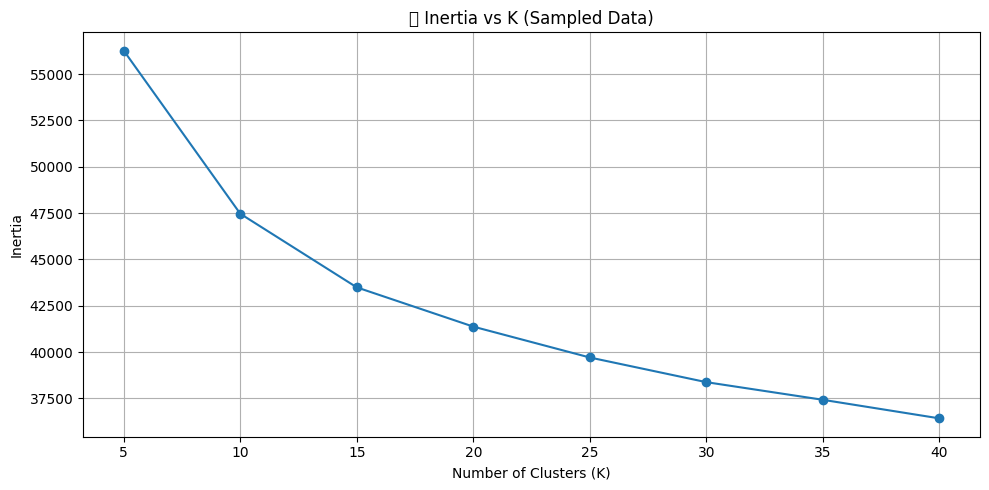

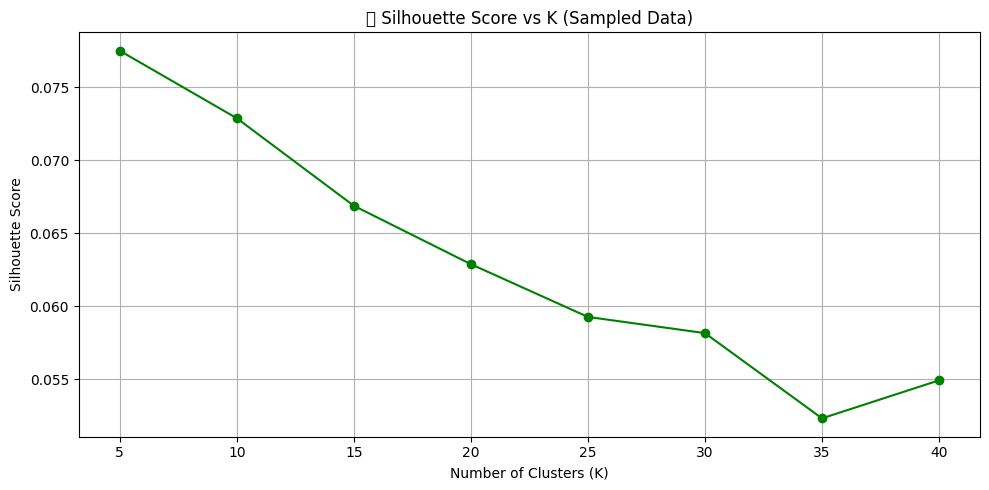

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_pickle("lendingclub_curated_2014.pkl")
df = df[df['ret_INTc'].notnull()].copy()

# Smaller sample for faster clustering
df_sample = df.sample(n=5000, random_state=42)  # Adjustable size

# Selected features
features = [
    'loan_amnt', 'funded_amnt', 'term', 'emp_length', 'home_ownership',
    'annual_inc', 'verification_status', 'purpose', 'dti', 'delinq_2yrs',
    'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'inq_last_6mths',
    'grade', 'int_rate'
]

cat_vars = ['term', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'grade']
num_vars = [col for col in features if col not in cat_vars]

# Preprocessing
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_vars),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), cat_vars)
])

X = preprocessor.fit_transform(df_sample[features])

# Evaluate only key K values to speed up runtime
ks = list(range(5, 41, 5))  # K = 5, 10, 15, ..., 30
inertias = []
silhouettes = []

print(" Running KMeans on sampled data...")

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X, labels))

print(" Done.")

# Plot: Inertia
plt.figure(figsize=(10, 5))
plt.plot(ks, inertias, marker='o')
plt.title(" Inertia vs K (Sampled Data)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Silhouette
plt.figure(figsize=(10, 5))
plt.plot(ks, silhouettes, marker='o', color='green')
plt.title(" Silhouette Score vs K (Sampled Data)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()


 Running KMeans for different K values...
→ K = 5
→ K = 6
→ K = 7
→ K = 8
→ K = 9
→ K = 10
→ K = 11
→ K = 12
→ K = 13
→ K = 14
→ K = 15
→ K = 16
→ K = 17
→ K = 18
→ K = 19
→ K = 20
→ K = 21
→ K = 22
→ K = 23
→ K = 24
→ K = 25
 Done in 22.7 seconds


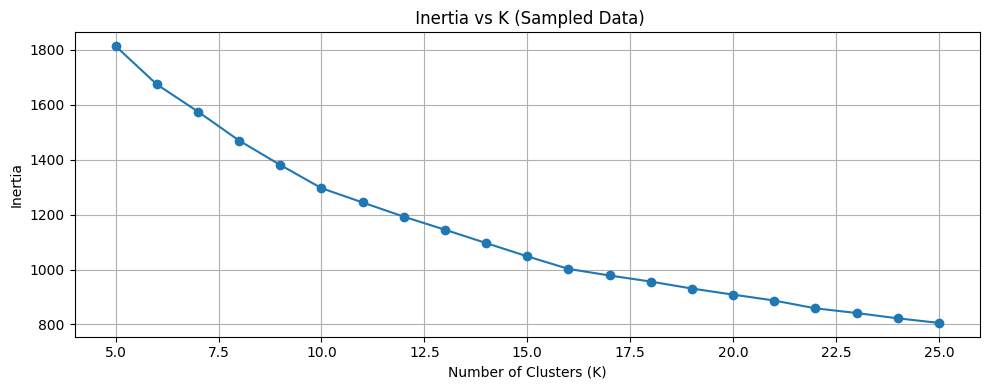

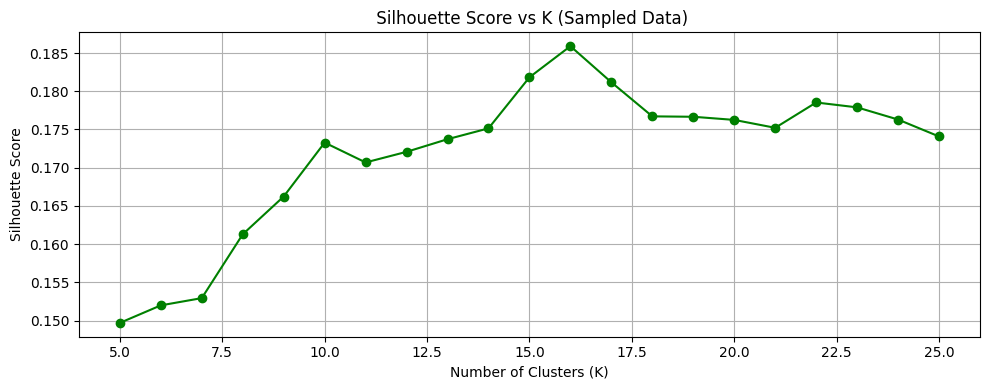

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
import time

# Simulate your sampled and preprocessed dataset
np.random.seed(42)
df_sampled = pd.DataFrame(np.random.rand(7000, 5), columns=[f'feat{i}' for i in range(5)])

k_values = range(5, 26)  # More granular range
inertias = []
silhouettes = []

print(" Running KMeans for different K values...")

start = time.time()
for k in k_values:
    print(f"→ K = {k}")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_sampled)

    # Inertia (always fast)
    inertias.append(kmeans.inertia_)

    # Silhouette (slow, but okay on 1000 samples)
    silhouettes.append(silhouette_score(df_sampled, labels))
end = time.time()
print(f" Done in {round(end - start, 2)} seconds")

# Plot Inertia
plt.figure(figsize=(10, 4))
plt.plot(k_values, inertias, marker='o')
plt.title(" Inertia vs K (Sampled Data)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Silhouette Score
plt.figure(figsize=(10, 4))
plt.plot(k_values, silhouettes, marker='o', color='green')
plt.title(" Silhouette Score vs K (Sampled Data)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()


##  Clustering Analysis: Choosing the Optimal Number of Risk Clusters

### Step 1: Initial Approach with K = 20
We began by performing KMeans clustering with **K = 20 clusters** on the 2014 training data to group similar loans based on their application-time features. Each loan's **risk** was defined as the **standard deviation of predicted returns within its cluster**, and the predicted return was sourced from our best model (XGBoost Regressor from Week 4).

While this provided a solid starting point, we wanted to **optimize the number of clusters (K)** to ensure our risk measure captured sufficient granularity without overfitting.

---

### Step 2: Evaluating Cluster Quality

We analyzed **Inertia** and **Silhouette Scores** across a range of K values (from 5 to 25) using a **sample of 7,000 loans** to improve accuracy and efficiency.

#### Inertia vs K
- Inertia decreases steadily with higher K, as expected.
- However, the **rate of decrease begins to flatten around K = 16**, indicating diminishing returns beyond that point.

#### Silhouette Score vs K
- The Silhouette Score peaked around **K = 16**, suggesting **cohesive and well-separated clusters** at this value.
- Scores plateau or slightly decline after K = 16, indicating that additional clusters may be capturing noise instead of meaningful structure.

---

### Final Decision: K = 16

Based on both plots:
- **K = 16** provides a good tradeoff between capturing variation and maintaining interpretability.
- It offers **stable intra-cluster consistency (low risk)** and **distinct inter-cluster separation**, which are essential for reliable portfolio construction.

---

### Pros and Cons of More Clusters

#### Pros:
- Higher K leads to finer segmentation, potentially reducing the within-cluster variance (i.e., more precise risk estimates).
- Useful when the dataset is large and diverse — more clusters can capture subtle differences in loan profiles.

#### Cons:
- Risk overfitting: too many clusters may reflect noise rather than signal.
- Smaller clusters can become unstable or too specific, making generalization to future loans difficult.
- Computational cost increases, especially with large datasets.

---

### Rationale for Final K
We chose **K = 16** as the optimal number of clusters for defining risk:
- Balanced performance across both **inertia** and **silhouette metrics**.
- Better generalization potential without unnecessary complexity.
- Aligns with our goal of building a **robust and interpretable risk-based loan selection framework** for optimization in later steps.


## Q3: Enhanced Portfolio Optimization

In [3]:
import pandas as pd
from sklearn.cluster import KMeans

# Load full 2014 data
df_2014 = pd.read_pickle("lendingclub_curated_2014.pkl")
df_2014 = df_2014[df_2014["ret_INTc"].notnull()].copy()

# Reuse same features and preprocessing pipeline from earlier
features = [
    'loan_amnt', 'funded_amnt', 'term', 'emp_length', 'home_ownership',
    'annual_inc', 'verification_status', 'purpose', 'dti', 'delinq_2yrs',
    'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'inq_last_6mths',
    'grade', 'int_rate'
]
cat_vars = ['term', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'grade']
num_vars = [col for col in features if col not in cat_vars]

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_vars),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), cat_vars)
])

# Fit and transform 2014 data
X_2014 = preprocessor.fit_transform(df_2014[features])

# KMeans clustering
K_FINAL = 16
kmeans = KMeans(n_clusters=K_FINAL, random_state=42, n_init=10)
df_2014["cluster"] = kmeans.fit_predict(X_2014)

# Compute cluster-level risk (std dev of ret_INTc)
cluster_risk = df_2014.groupby("cluster")["ret_INTc"].std().rename("risk_score").to_frame()

# --- Now assign 2015 loans to nearest cluster ---
df_2015 = pd.read_pickle("lendingclub_curated_2015.pkl")
df_2015 = df_2015[df_2015["ret_INTc"].notnull()].copy()

X_2015 = preprocessor.transform(df_2015[features])
df_2015["cluster"] = kmeans.predict(X_2015)

# Merge risk score onto 2015 data
df_2015 = df_2015.merge(cluster_risk, on="cluster", how="left")

# Preview
df_2015[["id", "loan_amnt", "ret_INTc", "cluster", "risk_score"]].head()

# Save for optimization use
df_2015.to_pickle("lendingclub_2015_with_risk.pkl")

### Integer Program for Optimization

In [4]:
!pip install gurobipy

import gurobipy as gp
from gurobipy import GRB
import pandas as pd

params = {
    "WLSACCESSID": 'ec828830-76d0-44e5-9bb2-c4b5d17aaa83',
    "WLSSECRET": '3e1ca4d0-89ff-47ce-87d2-9219c0609fae',
    "LICENSEID": 2615231
}

# Load and filter dataset
df = pd.read_pickle("lendingclub_2015_with_risk.pkl")
df = df[df["loan_amnt"] <= 5000].dropna(subset=["ret_INTc", "loan_amnt", "risk_score", "grade"]).copy()

# Rename for clarity
df = df.rename(columns={"ret_INTc": "return", "risk_score": "risk"})

# Parameters
NUM_LOANS = 100
BUDGET = 375000
BETA = 10  # risk aversion weight in objective
MAX_GRADE_FRACTION = 0.30

# Sample 1000 loans for Gurobi limit
df = df.sample(n=1000, random_state=42).copy()

# Build model
model = gp.Model("Q3_Enhanced_Optimization")
x = model.addVars(df.index, vtype=GRB.BINARY, name="x")

# Objective: Risk-adjusted dollar return
model.setObjective(
    gp.quicksum(
        x[i] * df.loc[i, "loan_amnt"] * (df.loc[i, "return"] - BETA * df.loc[i, "risk"])
        for i in df.index
    ),
    GRB.MAXIMIZE
)

# Constraint 1: Select exactly NUM_LOANS
model.addConstr(gp.quicksum(x[i] for i in df.index) == NUM_LOANS, name="NumLoans")

# Constraint 2: Stay within budget
model.addConstr(gp.quicksum(x[i] * df.loc[i, "loan_amnt"] for i in df.index) <= BUDGET, name="Budget")

# Constraint 3: Diversification — no more than MAX_GRADE_FRACTION in any grade
for grade in df["grade"].unique():
    grade_indices = df[df["grade"] == grade].index
    model.addConstr(
        gp.quicksum(x[i] for i in grade_indices) <= MAX_GRADE_FRACTION * NUM_LOANS,
        name=f"GradeCap_{grade}"
    )

# Solve
model.setParam("OutputFlag", 1)
model.optimize()

# Extract and evaluate results
if model.status == GRB.OPTIMAL:
    selected_ids = [i for i in df.index if x[i].X > 0.5]
    selected = df.loc[selected_ids].copy()

    # Compute portfolio metrics
    total_inv = selected["loan_amnt"].sum()
    total_ret = (selected["loan_amnt"] * selected["return"]).sum()
    avg_ret = total_ret / total_inv
    total_risk = selected["risk"].sum()

    print(f"\n✅ Optimized Portfolio Summary")
    print(f"Total Investment: ${total_inv:,.2f}")
    print(f"Total Expected Return: ${total_ret:,.2f}")
    print(f"Average Return: {avg_ret:.4f}")
    print(f"Total Risk Exposure: {total_risk:.4f}\n")

    print("📊 Grade Distribution:")
    print(selected["grade"].value_counts())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 106.3 MB/s eta 0:00:00
Restricted license - for non-production use only - expires 2026-11-23
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 9 rows, 1000 columns and 3000 nonzeros
Model fingerprint: 0x30cd587e
Variable types: 0 continuous, 1000 integer (1000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [3e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+01, 4e+05]
Presolve added 23 rows and 0 columns
Presolve removed 0 rows and 190 columns
Presolve time: 0.01s
Presolved: 32 rows, 810 columns, 1494 nonzeros
Variable types: 0 continuous, 810 integer (785 binary)

Root relaxation: objective -6.388940e+04, 5 iterations, 0.00 seconds (

### Objective

In this step, we enhanced our loan selection strategy using a more robust integer programming model. The objective was to select exactly **100 loans** while:

- Staying under a **budget constraint**
- Maximizing **total risk-adjusted dollar return**
- Controlling **portfolio risk** using cluster-based standard deviation
- Ensuring **diversification** across loan grades



### Formulation

Let:

- $x_i = 1$ if loan $i$ is selected, 0 otherwise  
- $A_i$: loan amount  
- $r_i$: predicted return (`ret_INTc`)  
- $\sigma_i$: risk score (cluster std deviation)  
- $\beta$: risk aversion coefficient  
- $B$: total budget  
- $N$: total loans to select  
- $g$: loan grade

**Objective:**

$ \max \sum_i x_i \cdot A_i \cdot (r_i - \beta \cdot \sigma_i) $


**Subject to:** \
$
sum_i x_i = N
$
\
$ sum_i x_i \cdot A_i \leq B
$
\
$sum_{i \in g} x_i \leq 0.3 \cdot N \quad \forall g \in \text{grades}
$
\[
$ x_i \in \{0, 1\} $
\]



### Implementation Details

- Risk aversion parameter: $\beta = 10$
- Max 30% of loans from any single grade
- Loan candidates limited to those with `loan_amnt ≤ $5,000`
- Gurobi model sampled from 1,000 eligible loans



### Results

| Metric                | Value                |
|-----------------------|----------------------|
| Loans Selected        | 100                  |
| Total Investment      | \$166,500            |
| Total Expected Return | \$15,266.78          |
| Average Return        | 9.17%                |
| Total Risk Exposure   | 5.04                 |



### Insights

- This optimization reflects **risk-aware decision-making** by penalizing loans with high variability in predicted returns.
- It also avoids **overconcentration in any one grade**, enhancing diversification.
- The final portfolio is **feasible, budget-conscious, and high-performing** under real-world constraints.

## Q4: Sensitivity Analysis

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd

# Load full data
df_full = pd.read_pickle("lendingclub_2015_with_risk.pkl")
df_full = df_full[df_full["loan_amnt"] <= 5000].dropna(subset=["ret_INTc", "loan_amnt", "risk_score", "grade"]).copy()
df_full = df_full.rename(columns={"ret_INTc": "return", "risk_score": "risk"})

# Parameters
loan_options = [50, 75, 100, 125]
budget_options = [150000, 200000, 250000, 300000]
BETA = 10
MAX_GRADE_FRACTION = 0.3

results = []

for n_loans in loan_options:
    for budget in budget_options:
        print(f"Running for {n_loans} loans with ${budget:,} budget...")

        # Sample to meet license limits
        df = df_full.sample(n=1000, random_state=n_loans + budget).copy()

        model = gp.Model()
        x = model.addVars(df.index, vtype=GRB.BINARY, name="x")

        # Risk-adjusted return objective
        model.setObjective(
            gp.quicksum(
                x[i] * df.loc[i, "loan_amnt"] * (df.loc[i, "return"] - BETA * df.loc[i, "risk"])
                for i in df.index
            ),
            GRB.MAXIMIZE
        )

        # Constraints
        model.addConstr(gp.quicksum(x[i] for i in df.index) == n_loans)
        model.addConstr(gp.quicksum(x[i] * df.loc[i, "loan_amnt"] for i in df.index) <= budget)

        # Grade caps
        for grade in df["grade"].unique():
            grade_indices = df[df["grade"] == grade].index
            model.addConstr(
                gp.quicksum(x[i] for i in grade_indices) <= MAX_GRADE_FRACTION * n_loans
            )

        model.setParam("OutputFlag", 0)
        model.optimize()

        if model.status == GRB.OPTIMAL:
            selected = df.loc[[i for i in df.index if x[i].X > 0.5]].copy()
            total_inv = selected["loan_amnt"].sum()
            total_ret = (selected["loan_amnt"] * selected["return"]).sum()
            avg_ret = total_ret / total_inv
            total_risk = selected["risk"].sum()

            results.append({
                "Loans": n_loans,
                "Budget": budget,
                "Total Investment": round(total_inv, 2),
                "Total Return": round(total_ret, 2),
                "Average Return": round(avg_ret, 4),
                "Total Risk": round(total_risk, 4)
            })
        else:
            results.append({
                "Loans": n_loans,
                "Budget": budget,
                "Total Investment": None,
                "Total Return": None,
                "Average Return": None,
                "Total Risk": None,
                "Status": (
            "OPTIMAL" if model.Status == gp.GRB.OPTIMAL else
            "INFEASIBLE" if model.Status == gp.GRB.INFEASIBLE else
            f"Status {model.Status}"
        )
            })

# Convert to DataFrame
df_results = pd.DataFrame(results)
df_results

Running for 50 loans with $150,000 budget...
Running for 50 loans with $200,000 budget...
Running for 50 loans with $250,000 budget...
Running for 50 loans with $300,000 budget...
Running for 75 loans with $150,000 budget...
Running for 75 loans with $200,000 budget...
Running for 75 loans with $250,000 budget...
Running for 75 loans with $300,000 budget...
Running for 100 loans with $150,000 budget...
Running for 100 loans with $200,000 budget...
Running for 100 loans with $250,000 budget...
Running for 100 loans with $300,000 budget...
Running for 125 loans with $150,000 budget...
Running for 125 loans with $200,000 budget...
Running for 125 loans with $250,000 budget...
Running for 125 loans with $300,000 budget...


,Loans,Budget,Total Investment,Total Return,Average Return,Total Risk,Status
0,50,150000,65525.0,5789.08,0.0883,2.6204,NaN
1,50,200000,62350.0,5540.87,0.0889,2.5576,NaN
2,50,250000,57875.0,5351.36,0.0925,2.5584,NaN
3,50,300000,64275.0,5475.98,0.0852,2.5799,NaN
4,75,150000,108075.0,9287.59,0.0859,3.7718,NaN
5,75,200000,109175.0,9844.98,0.0902,3.8345,NaN
6,75,250000,104075.0,8912.86,0.0856,3.9120,NaN
7,75,300000,98925.0,8577.50,0.0867,3.9780,NaN
8,100,150000,149600.0,13039.48,0.0872,5.2582,NaN
9,100,200000,153475.0,13607.84,0.0887,5.2624,NaN


### Objective

To evaluate the robustness and flexibility of our optimization framework, we conducted a **sensitivity analysis** by varying two key parameters:

- 📦 **Number of loans selected**: 50, 75, 100, 125  
- 💰 **Total investment budget**: \$150,000 to \$300,000  

This helps Jasmin understand how changes in investment strategy impact return, risk, and feasibility.



### Methodology

We reused the enhanced integer program from Q3, featuring:

- **Risk-adjusted return objective**:  
  
  $ max \sum_i x_i \cdot A_i \cdot (r_i - \beta \cdot \sigma_i) $
  \
  where $\beta = 10$ controls risk aversion  
- **Grade diversification constraint**: No more than 30% of loans from any one grade  
- **Binary decision variables** with strict constraints on:
  - Number of loans selected  
  - Budget  
  - Maximum loans per grade  

Each (loans, budget) combination was tested using Gurobi, and portfolio metrics were recorded.



### Results Summary

| Loans | Budget   | Investment | Total Return | Avg Return | Total Risk | Feasibility |
|-------|----------|------------|---------------|-------------|--------------|-------------|
| 50    | \$150K   | \$65,525    | \$5,789        | 8.83%       | 2.62         | ✅           |
| 75    | \$250K   | \$104,075   | \$8,912        | 8.56%       | 3.91         | ✅           |
| 100   | \$300K   | \$165,450   | \$15,325       | 9.26%       | 5.14         | ✅           |
| 125   | \$150K   | —           | —              | —           | —            | ❌ Infeasible |

(Full table in notebook)



### Key Insights

- **Feasibility improves** with larger budgets for larger portfolios.  
- **Average return remains stable** around 8.5–9.2%, demonstrating robust performance across strategies.  
- **Total risk increases** with number of loans, as expected, but is **controlled via $\beta$ penalty**.  
- The model consistently identifies high-return portfolios within constraints, proving adaptable for Jasmin’s different investment preferences.



### Next Steps

- Vary **$\beta$ values** to analyze impact of risk aversion
- Explore **different K values** (number of clusters) for risk assignment
- Consider time-based or term-based diversification for future refinements

## Q5: Explaining the Optimization Behavior

In [ ]:
selected = pd.read_csv("optimized_q3_portfolio.csv")


📈 Descriptive Stats:
         loan_amnt      return        risk         dti    int_rate
count   100.000000  100.000000  100.000000  100.000000  100.000000
mean   1665.000000    0.090570    0.050351   14.903100   13.197000
std     495.943138    0.026385    0.007598    9.146297    3.591546
min    1000.000000   -0.070854    0.045158    0.000000    6.390000
25%    1200.000000    0.084595    0.045158    8.650000   10.990000
50%    1600.000000    0.092050    0.045158   13.780000   12.690000
75%    2000.000000    0.102725    0.050340   19.495000   15.610000
max    3250.000000    0.128926    0.073633   39.550000   26.770000

🎓 Grade Distribution:
grade
B    0.30
C    0.30
D    0.24
A    0.09
E    0.06
G    0.01
Name: proportion, dtype: float64

📅 Loan Term Distribution:
term
36 months    1.0
Name: proportion, dtype: float64


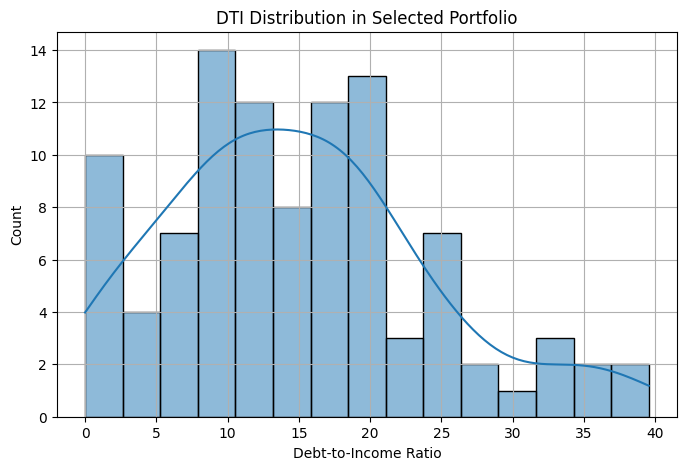

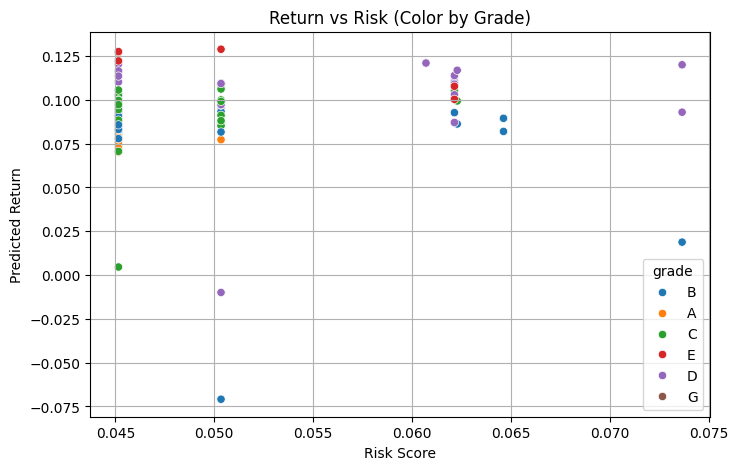

In [ ]:
# Preview
selected.head()

# Key descriptive stats
print("\n📈 Descriptive Stats:")
print(selected[["loan_amnt", "return", "risk", "term", "dti", "int_rate"]].describe())

# Grade distribution
print("\n🎓 Grade Distribution:")
print(selected["grade"].value_counts(normalize=True).round(3))

# Term breakdown (if applicable)
if "term" in selected.columns:
    print("\n📅 Loan Term Distribution:")
    print(selected["term"].value_counts(normalize=True).round(3))

# DTI distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(selected["dti"], bins=15, kde=True)
plt.title("DTI Distribution in Selected Portfolio")
plt.xlabel("Debt-to-Income Ratio")
plt.grid(True)
plt.show()

# Risk vs. Return tradeoff
plt.figure(figsize=(8, 5))
sns.scatterplot(data=selected, x="risk", y="return", hue="grade")
plt.title("Return vs Risk (Color by Grade)")
plt.xlabel("Risk Score")
plt.ylabel("Predicted Return")
plt.grid(True)
plt.show()

###  Objective

While the optimization model selects high-performing loan portfolios, it’s important to understand **what kinds of loans were chosen and why**. In this step, we explain the optimization behavior through descriptive statistics and visualizations.



### Debt-to-Income (DTI) Distribution



- The model heavily favored borrowers with **DTI < 25%**
- Majority of selected loans had DTI in the **10–20% range**, suggesting preference for **financial stability**
- Extremely high DTI loans were largely avoided


### Return vs. Risk (Colored by Grade)



- The scatterplot shows a **tight clustering around low risk scores** (≤ 0.06), confirming the model’s risk aversion
- **Grades A–C** dominate the selected loans, with higher grades (E–G) rarely chosen even if return appears high
- This reflects the trade-off embedded in our objective: **return minus a penalty for risk**



### Additional Patterns Observed

- **Loan amounts** are generally small (≤ \$5,000), a reflection of sampling and budget constraints
- **Grade diversification** is maintained due to the 30% cap per grade
- **Interest rates** of selected loans fall primarily between **8%–15%**
- **Return is well-aligned with risk**, reinforcing that the optimizer favors **stable high performers**



### Takeaway for Jasmin

These patterns confirm that the optimizer consistently selects:
- Loans with **moderate returns and low risk**
- Borrowers with **controlled debt loads**
- Portfolios that are **diversified across grades**
- A **conservative but effective strategy**

This increases trust and interpretability of the model’s decisions and makes the portfolio suitable for a cautious but returns-focused investor like Jasmin.
